In [1]:
# Jun 3rd 2022
# Author: Jose Bastias
# Description: Python code to read raw data from the Mary Wildman dataset. 
# Actions: 
#          1.- Read the original csv/excel files - time series, head and atm pressure
#          2.- Transform the time data into readable format using only pandas automatic time recog algorithm
#          3.- Clean outliers with "hampel"
#          4.- Plot and save

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hampel import hampel
import pickle

plt.style.use('ggplot')
myColor  = ("#E3072A","#0A8974","#5FAECC","#E49C23","#E27520") # Darjeeling Color map

Read the data from raw founder. Make sure you first look at how many rows do you need to skip!

In [45]:
# Boring things to get to the data
sites = ['B1', 'B2']  

path = ''
foulder = ''
data_files = ['B1.xlsx', 'B2.csv']  

skip_rows = ['0', '65']


# Read data and save it in a dictionary

raw_dic = {}

for i, j, k in zip(sites, data_files, skip_rows):
    
    if 'xlsx' in j:
        raw_data = pd.read_excel(path + i + '/' + foulder + '/' + j, skiprows = int(k))
        raw_data['Date and Time'] = pd.to_datetime(raw_data['Date and Time'])
    if 'csv' in j:
        raw_data = pd.read_csv(path + i + '/' + foulder + '/' + j, skiprows = int(k))
        raw_data['Date and Time'] = pd.to_datetime(raw_data['Date and Time'])
    
    raw_dic[i] = raw_data

raw_dic.keys()

/tmp/ipykernel_20360/1614028488.py:22: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S     format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  raw_data['Date and Time'] = pd.to_datetime(raw_data['Date and Time'])


dict_keys(['B1', 'B2'])

Now we will take outliers out base on hampel of Python that works well most of the time

In [46]:
# First a tedius thing to do, is to look for the columns where the head and baro pressure are.

column_head = ['2', '3']
column_baro = ['1', '1']

clean_dic = {}
outliers = {}
datum = 43
# Find outliers
for i, j in enumerate(raw_dic):
    print('working on data set ' + sites[i])
    
    if sites[i] == 'B2':
        # In this case the head is measured differently (from the bottom)
        time_serie_r = raw_dic[j].iloc[:, 0].values
        head_r = 10.3109 - raw_dic[j].iloc[:, int(column_head[i])].values
        baro_r = raw_dic[j].iloc[:, int(column_baro[i])].values
        
    else: 
        # Keep important variables
        time_serie_r = raw_dic[j].iloc[:, 0].values
        head_r = raw_dic[j].iloc[:, int(column_head[i])].values
        baro_r = raw_dic[j].iloc[:, int(column_baro[i])].values
        
    # Quick out outliers
    ts_out_head = hampel(pd.Series(head_r), window_size=20, n=8)
    ts_out_baro = hampel(pd.Series(baro_r), window_size=20, n=8)
    
    print(str(len(ts_out_head)) + ' head outliers found!')
    print('----------------------------------------------------------')
    
    # Take outliers out
    head = datum - np.delete(head_r, ts_out_head)
    baro = np.delete(baro_r, ts_out_head)
    time_serie = np.delete(time_serie_r, ts_out_head)
    
    head_out = datum - np.take(head_r, ts_out_head)
    baro_out = np.take(baro_r, ts_out_head)
    time_out = np.take(time_serie_r, ts_out_head)
    
    if sites[i] == 'B1':
        head = head[130:]
        baro = baro[130:]
        time_serie = time_serie[130:]    
        
    # Save results in dic
    clean_dic[sites[i]] = pd.DataFrame(zip(time_serie, head, baro), columns = ['date', 'head[m]', 'baro[kPa]'])
    outliers[sites[i]] = pd.DataFrame(zip(time_out, head_out, baro_out), columns = ['date', 'head[m]', 'baro[kPa]'])
    

working on data set B1
0 head outliers found!
----------------------------------------------------------
working on data set B2
27 head outliers found!
----------------------------------------------------------


Now we have got the data in a dictionary, we can plot!

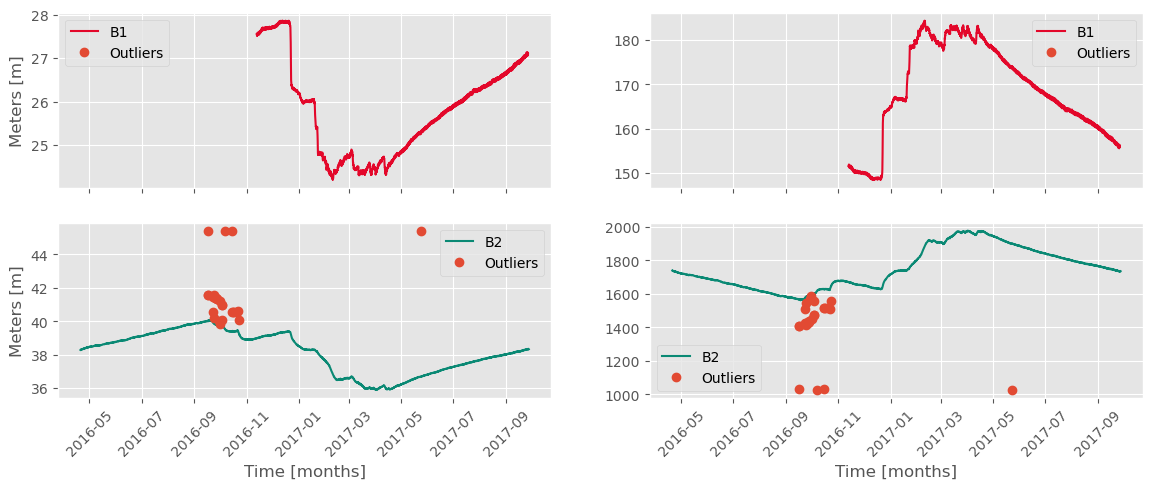

In [47]:
fig, ax = plt.subplots(nrows= len(sites),ncols=2,figsize=(14.0,5.0), sharex = True) # ,sharey=True

for i, site in enumerate(sites):
    
    #Lets plot first the head
    ax[i,0].plot(clean_dic[site]['date'],clean_dic[site]['head[m]'], label = site, color=myColor[i])
    ax[i,0].plot(outliers[site]['date'], outliers[site]['head[m]'], 'o',label = 'Outliers')
    ax[i,0].set_ylabel('Meters [m]')
    ax[i,0].legend()
    
    ax[i,1].plot(clean_dic[site]['date'],clean_dic[site]['baro[kPa]'], label = site, color=myColor[i])
    ax[i,1].plot(outliers[site]['date'], outliers[site]['baro[kPa]'], 'o',label = 'Outliers')
    ax[i,1].legend()
    
ax[i,0].set_xlabel('Time [months]')
ax[i,1].set_xlabel('Time [months]')
ax[i,0].tick_params(axis='x', labelrotation=45)
ax[i,1].tick_params(axis='x', labelrotation=45)


In [48]:
# Save results
path = 'Results/pkl_files/'

with open(path + 'cleaned_data.pkl', 'wb') as f:
    pickle.dump(clean_dic, f)